### Ecuación de la convección bidimensional

Recordemos que partiimos desde la ley de conservación en forma diferencial, despreciando los efectos difusivos:

\begin{equation}
\frac{\partial \rho b}{\partial t}+\vec{\nabla} \cdot(\rho b \vec{v})=0
\end{equation}

 Si seguimos trabajando la ecuación anterior, podemos llegar a la siguientes expresión que es completamente equivalente:
 
 \begin{equation}
\frac{\partial \rho b}{\partial t}+(\vec{v} \cdot \vec{\nabla}) \rho b + \rho b \vec{\nabla} \cdot \vec{v}=0
\end{equation}

Si el campo de velocidad es constante, luego el tercer termino es igual a cero y nos queda:

\begin{equation}
\frac{\partial \rho b}{\partial t}+(\vec{v} \cdot \vec{\nabla}) \rho b = 0
\end{equation}

Para la ecuación de la onda, donde $u$ es la velocidad, la densidad es unitaria y $c$ es la velocidad y es constante llegamos a:

\begin{equation}
\frac{\partial u}{\partial t}+c \frac{\partial u}{\partial x}+c \frac{\partial u}{\partial y}=0
\end{equation}

\begin{equation}
\frac{\partial \rho \phi}{\partial t} + \nabla \cdot (\rho \phi \vec{V}) = \nabla \cdot (\Gamma \nabla \phi)
\end{equation}

\begin{equation}
\rho \frac{\partial \phi}{\partial t} + \rho (\vec{V} \cdot \nabla) \phi = \nabla \cdot (\Gamma \nabla \phi)
\end{equation}


In [1]:
#Librería para plotear en 3D
from mpl_toolkits.mplot3d import Axes3D

#Incluímos las librerías que vamos a usar
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time, sys

In [19]:
class domain:
    #El constructor se encarga de hacer el preprocesamiento
    def __init__(self, Lx, Ly, T, c, dx, dy, dt):       
        self.Nx = int(Lx/dx)                   #Número de puntos desde 0 hasta Nx
        self.x = np.linspace(0, Lx, self.Nx+1)   #Creo un vector que va desde el 0 hasta Lx con Nx+1 divisiones
        self.dx = self.x[1]-self.x[0]          #Chequeo del dx, para que coincida
        
        self.Ny = int(Ly/dy)                   #Número de puntos desde 0 hasta Ny
        self.y = np.linspace(0, Ly, self.Ny+1)   #Creo un vector que va desde el 0 hasta Ly con Ny+1 divisiones
        self.dy = self.y[1]-self.y[0]          #Chequeo del dy, para que coincida

        self.Nt = int(T/dt)                   #Número de puntos desde 0 hasta Nt
        self.t = np.linspace(0, T, self.Nt+1)   #Creo un vector que va desde el 0 hasta T con Nt+1 divisiones
        self.dt = self.t[1]-self.t[0]         #Chequeo del dt, para que coincida

        self.CFLx = c*self.dt/self.dx          #Calculo el número de Courant
        self.CFLy = c*self.dt/self.dy          #Calculo el número de Courant
        
        #Creamos dos matrices: una representa el tiempo presente y la otra el tiempo futuro
        self.u_2 = np.zeros((self.Nx+1, self.Ny+1))
        self.u_1 = np.zeros((self.Nx+1, self.Ny+1))

    
    #En este método incluimos la condición inicial para t=0 en todo el dominio x,y
    def initialCond(self):
        #Añadimos la condición inicial en la posicón del presente
        self.u_1[int(0.3/self.dx):int(0.6/self.dx), int(0.3/self.dy):int(0.6/self.dy)] = 1.5
        
        #Graficamos la condición inicial
        fig = plt.figure(figsize=(11, 7), dpi=100)       #Creo una ventana para graficar llamada fig
        ax = plt.axes(projection='3d')                   #Para crear ejes en las tres dimensiones
        self.X, self.Y = np.meshgrid(self.x, self.y)     #Creo un enmallado usando los vectores unidimensionales
        ax.plot_surface(self.X, self.Y, self.u_1, rstride=1, cstride=1,
                cmap='plasma', edgecolor='none')
        #ax.view_init(40, 40)
        ax.set_xlabel('x[m]')
        ax.set_ylabel('y[m]')
        ax.set_zlabel('Velocidad[m/s]')
        ax.set_title('Condiciones iniciales t=%.2f' % self.t[0])
        
    def solver_loop(self):
        #En este método resolvemos la ecuación convectiva por medio de un loop for
        self.row, self.col = self.u_1.shape
        
        for n in range(1, self.Nt):
            #Definimos los valores de la frontera
            self.u_2[:, 0] = 0   #Para todas las filas, columna 0
            self.u_2[:, -1] = 0  #Para todas las filas, última columna
            self.u_2[0, :] = 0   #Para todas las columnas, fila 0
            self.u_2[-1, :] = 0  #Para todas las columnas, última fila
            
            for j in range(1, self.row-1):
                for i in range(1, self.col-1):
                    self.u_2[j, i] = self.u_1[j, i] -self.CFLx*(self.u_1[j, i] - self.u_1[j, i-1])  -\
                                     self.CFLy*(self.u_1[j, i] - self.u_1[j-1, i])
            #Actualizamos
            self.u_1 = self.u_2.copy()
                    
    def solver_vector(self):
        #En este método resolvemos la ecuación convectiva por de la vectorización
        self.row, self.col = self.u_1.shape
        for n in range(1, self.Nt):
            #Definimos los valores de la frontera
            self.u_2[:, 0] = 0   #Para todas las filas, columna 0
            self.u_2[:, -1] = 0  #Para todas las filas, última columna
            self.u_2[0, :] = 0   #Para todas las columnas, fila 0
            self.u_2[-1, :] = 0  #Para todas las columnas, última fila
            
            self.u_2[1:-1, 1:-1] = self.u_1[1:-1, 1:-1] -self.CFLx*(self.u_1[1:-1, 1:-1] - self.u_1[1:-1, :-2]) - \
                                   self.CFLy*(self.u_1[1:-1, 1:-1] - self.u_1[0:-2, 1:-1])
            #Actualizamos
            self.u_1 = self.u_2.copy()
            
            
        
    def plotter_3D(self):
        fig = plt.figure(figsize=(11, 7), dpi=100)       #Creo una ventana para graficar llamada fig
        ax = plt.axes(projection='3d')                   #Para crear ejes en las tres dimensiones
        ax.plot_surface(self.X, self.Y, self.u_2[:], rstride=1, cstride=1,
                        cmap='plasma', edgecolor='none')
        #ax.view_init(40, 40)
        ax.view_init(20, 290)
        ax.set_xlabel('x[m]')
        ax.set_ylabel('y[m]')
        ax.set_zlabel('Velocidad[m/s]')
        ax.set_title('Condiciones iniciales t=%.2f' % self.t[-1])
        ax.set_zlim(0, 1.2)
        
            

In [23]:
#Definimos las propiedades y condiciones de simulación
Lx = 2
Ly = 2
T = 1.0
c = 0.8
dx = 0.05
dy = 0.05
dt = 0.01

#Creo el objeto string
surface = domain(Lx, Ly, T, c, dx, dy, dt)

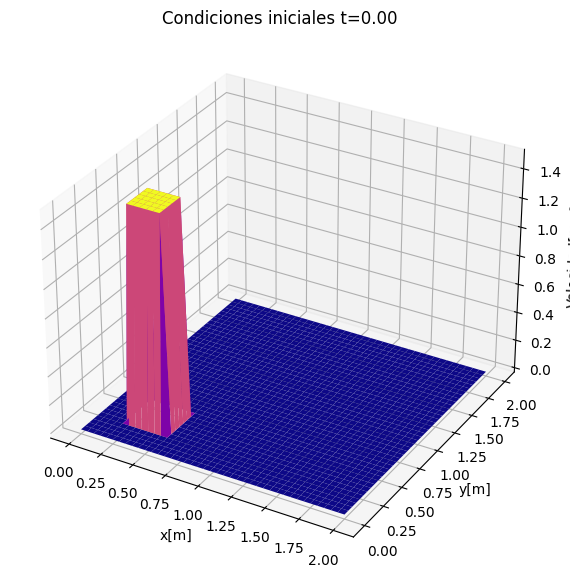

In [24]:
#Grafico las condiciones iniciales
surface.initialCond()

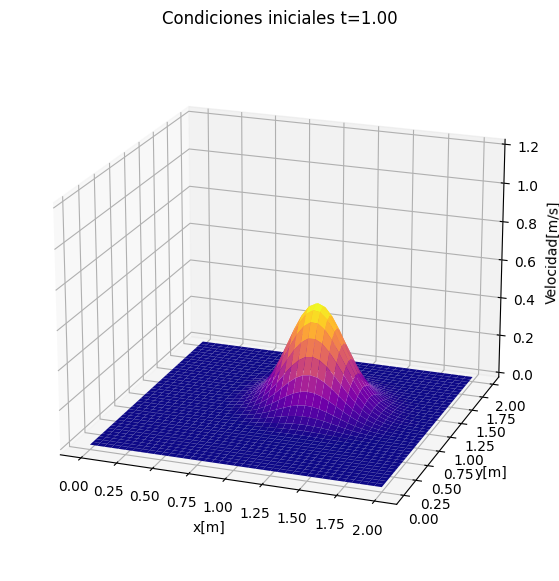

In [25]:
surface.solver_loop()
surface.plotter_3D()